# Read in Void Catalogs

Instructions: First run `python SDSSVpidFinder_dr7.py` to generate `vollim_dr7_cbp_102709_VoidFinder_Output.fits` and run `vsquared.py -m 4 -c DR7_config.ini -v`* to generate `DR7_V2_REVOLVER_Output.fits`

\*The `-m 4` choses REVOLVER as out V2 pruning method. We can alternatively use `-m 0` for VIDE or `-m 1` for ZOBOV. The `-v` causes the algorithm to calculate rendering information for the voids that we can use to make slice plots (warning: this adds signifigantly to the runtime)

In [1]:
# Import the void catalog class
from vast.catalog.void_catalog import VoidFinderCatalog, V2Catalog

In [2]:
# Data paths
voidfinder_voids_path = 'vollim_dr7_cbp_102709_VoidFinder_Output.fits'
vsquared_voids_path = 'DR7_V2_REVOLVER_Output.fits'
galaxies_path = 'vollim_dr7_cbp_102709.fits'

In [3]:
# Load void catalogs and add galaxies
voidfinder_catalog = VoidFinderCatalog(voidfinder_voids_path)
voidfinder_catalog.add_galaxies(galaxies_path, redshift_name='z')
vsquared_catalog = V2Catalog(vsquared_voids_path)
vsquared_catalog.add_galaxies(galaxies_path, redshift_name='z')

# Note: if our void catalog is split across multiple files (such as having an NGC and SGC catalog, we can load the catalog with)
# from vast.catalog.void_catalog import VoidFinderCatalogStacked, V2CatalogStacked
# voidfinder_catalog = VoidFinderCatalogStacked(['NGC','SGC'],[voidfinder_voids_ngc_path, voidfinder_voids_sgc_path])
# We can then index into the files like so
# voidfinder_catalog['NGC']

# Note: The catalogs by defualt apply a 30 Mpc/h edge buffer to the reported statistics for the void volume fraction and 
# galaxy void membership. This buffer helaps reduce survey edge effects. If we wishe to remove the edge buffer, we can do this:
# voidfinder_catalog = VoidFinderCatalog(voidfinder_voids_path, edge_buffer=0)


In [4]:
# For the full analysis of the V2 catalog, we need to give it an angular survey mask. 
# We can give it the voidfinder catalogs' mask, which is saved by that algorithm
vsquared_catalog.mask = voidfinder_catalog.mask
vsquared_catalog.mask_info = voidfinder_catalog.mask_info
vsquared_catalog.info['MSKRES'] = voidfinder_catalog.info['MSKRES']

# Catalog General Properties

In [15]:
# Calculate VoidFinder-specific properties
# This may take a while, particularly the effective radius calculation
vflag_path = 'vollim_dr7_cbp_102709_VoidFinder_vflags.fits' #output destination for vflag calculation
voidfinder_catalog.calculate_vflag(vflag_path) #void galaxy membership
voidfinder_catalog.calculate_r_eff() #effective void radii


Identifying environment


In [5]:
# After we create a file identifying which galaxies are in VoidFidner voids, we can load it in
# instead of running calculate_vflag
vflag_path = 'vollim_dr7_cbp_102709_VoidFinder_vflags.fits' #output destination for vflag calculation
voidfinder_catalog.add_galaxies(galaxies_path, vflag_path = vflag_path, redshift_name='z')

In [6]:
# Print text highlighted in red
redtext = lambda x: f"\x1b[31m{x}\x1b[0m"

In [8]:
# Calculate catalog properties
print('\n'+redtext("SDSS VoidFinder"),'\n')
voidfinder_catalog.void_stats()
print('\n'+redtext("SDSS V2/REVOLVER"),'\n')
# Note that V2 will not output edge void statistics unless we use a branch of VAST that calculates 
# them during the voidfinding (e.g., https://github.com/DESI-UR/VAST/tree/fits_edge)
vsquared_catalog.void_stats()


SDSS VoidFinder 

897 voids
306 edge voids
15 near-edge voids
576 interior voids
3 edge voids (V. Fid)
0 near-edge voids (V. Fid)
464 interior voids (V. Fid)
Mean Reff (V. Fid): 16.83 +/- 0.107 Mpc/h
Median Reff (V. Fid): 16.22 +/- 0.134 Mpc/h
Maximum Reff (V. Fid): 28.92 Mpc/h

SDSS V2/REVOLVER 

437 voids
Mean Reff (V. Fid): 19.87 +/- 0.319 Mpc/h
Median Reff (V. Fid): 18.7 +/- 0.4 Mpc/h
Maximum Reff (V. Fid): 41.09 Mpc/h


# Void Volume Fraction

In [40]:
# Here we calculate the void volume fraction by creating a dense grid of points over the survey volume and 
# counting up the number of points inside and outside of voids.
# This may take a while to calculate
num_points_total, fraction_in_void, fraction_not_in_void = voidfinder_catalog.get_single_overlap()
voidfinder_volume_fraction = fraction_in_void
print(f'{voidfinder_volume_fraction * 100:.2f} percent of survey volume in VoidFinder voids')
num_points_total, fraction_in_void, fraction_not_in_void = vsquared_catalog.get_single_overlap()
vsquared_volume_fraction = fraction_in_void
print(f'{vsquared_volume_fraction * 100:.2f} percent of survey volume in V2/REVOLVER voids')

# Note: we can use vast.catalog.void_catalog.get_overlap to calculate the combined volume fraction statistics 
# of two overlapping void catalogs

64.97 percent of survey volume in VoidFinder voids
99.25 percent of survey volume in V2/REVOLVER voids


In [12]:
# The galaxy catalog we loaded in doesn't report the magnitudes, so let's 
# set the magnitudes to a value that will pass the cut (needed for subsequent calculations)
voidfinder_catalog.galaxies['rabsmag'] = -30
vsquared_catalog.galaxies['rabsmag'] = -30
vsquared_catalog.info['MAGLIM'] = 9999 # The V2 DR7 config file doesn't include a magnitude limit, so let's add one

In [8]:
# Here we calculate how many galaxies in our catalog are located within voids
# Note that this may not be the same as the fraction of the voidfinding input galaxies within voids
# as the galaxy catalog may have had additonal cuts applied (magnitude, redshift etc.) before it was 
# inputted to the voidfinding algorithm.
num_galaxies_in_void, num_galaxies = voidfinder_catalog.galaxy_membership()
# Note: by default the survey magnitude cut is applied. If we wish to disable it, we can instead do
#num_galaxies_in_void, num_galaxies = voidfinder_catalog.galaxy_membership(mag_lim=9999)
voidfinder_galaxy_fraction = num_galaxies_in_void / num_galaxies
print(f'{voidfinder_galaxy_fraction * 100:.2f} percent of galaxies are in VoidFinder voids')
# Note: if we want a boolean index to select galaxies in voids, we can run 
# boolean_index, num_galaxies = voidfinder_catalog.galaxy_membership()
num_galaxies_in_void, num_galaxies = vsquared_catalog.galaxy_membership()
vsquared_galaxy_fraction = num_galaxies_in_void / num_galaxies
print(f'{vsquared_galaxy_fraction * 100:.2f} percent of galaxies are in V2/REVOLVER voids')

# Note: we can use vast.catalog.void_catalog.combined_galaxy_membership to calculate the combined 
# galaxy-void membership statistics of two overlapping void catalogs

22.03 percent of galaxies are in VoidFinder voids
98.72 percent of galaxies are in V2/REVOLVER voids


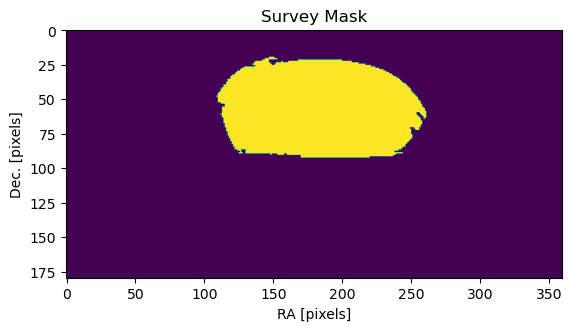

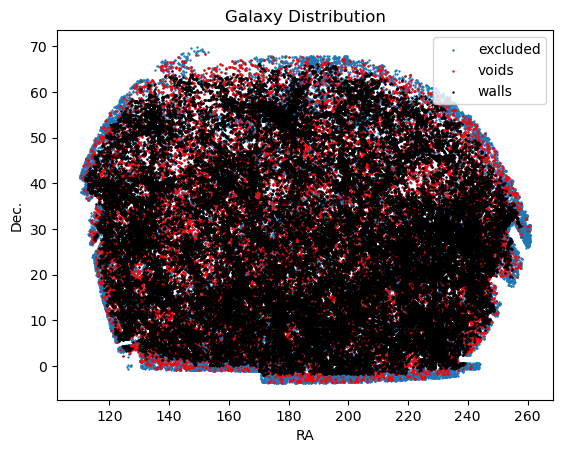

In [8]:
# For VoidFinder only, we have a built in function for plotting the angular distribution of the galaxies, 
# color-coded by their void membership
voidfinder_catalog.plot_vflag()

# Void Slice Plots

In [8]:
from vast.catalog.void_slice_plots import VoidMapVF, VoidMapV2
import matplotlib.pyplot as plt

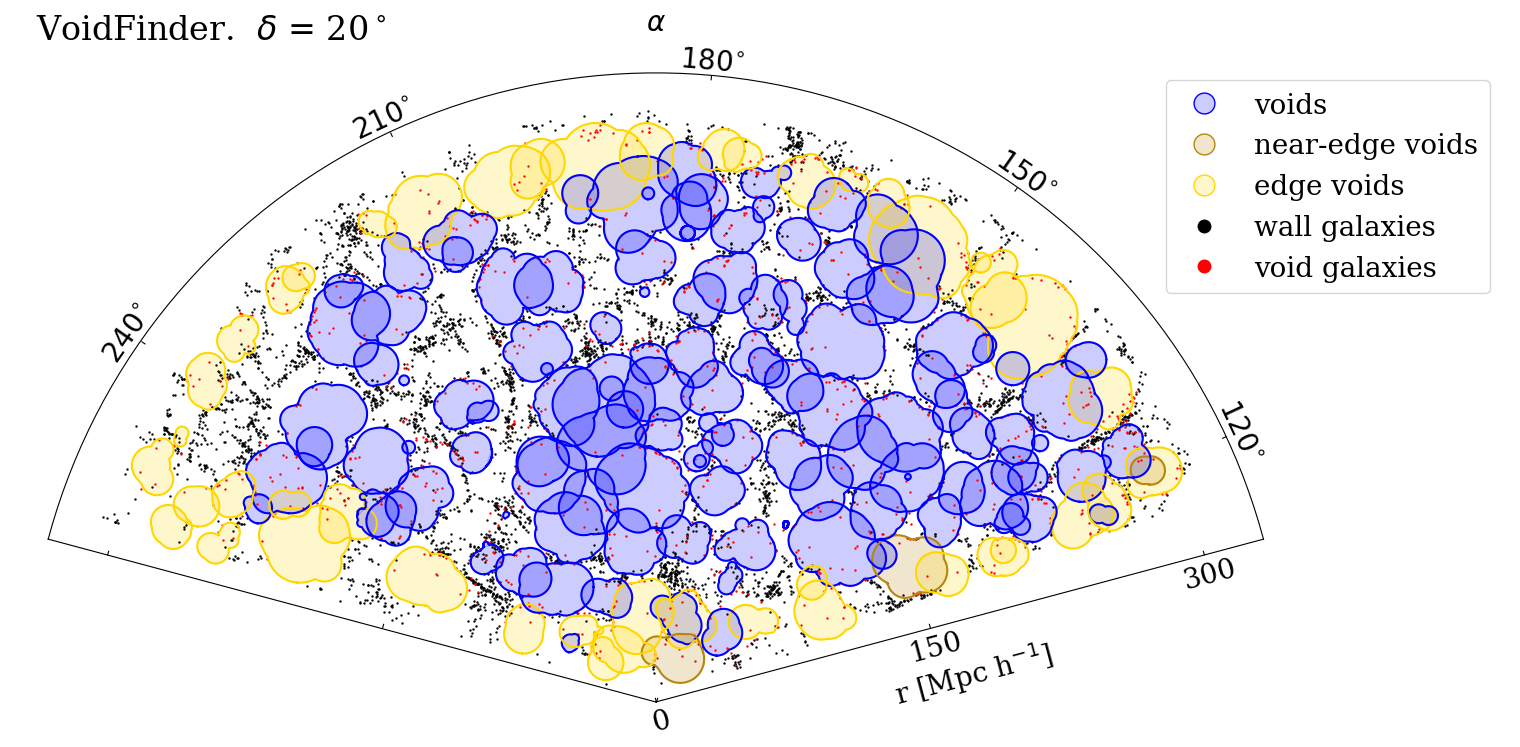

In [20]:
voidfinder_slice_plot = VoidMapVF(voidfinder_catalog.galaxies, voidfinder_catalog.maximals, voidfinder_catalog.holes)

plt.rcParams.update({'font.size': 20, 'font.family':'serif',"axes.titley":1.03 })

graph = voidfinder_slice_plot.plot_survey(20,5,1500,15, 
    110, 260, 0, 0.114, "VoidFinder. ", graph = None, zlimits = True, rot = 265, 
    colors = ['gold','darkgoldenrod','blue'],include_gals=True,alpha=0.2, border_alpha = 1,
    horiz_legend_offset=0.9,mag_limit=-20, galaxy_point_size=.5, plot_sdss=False)

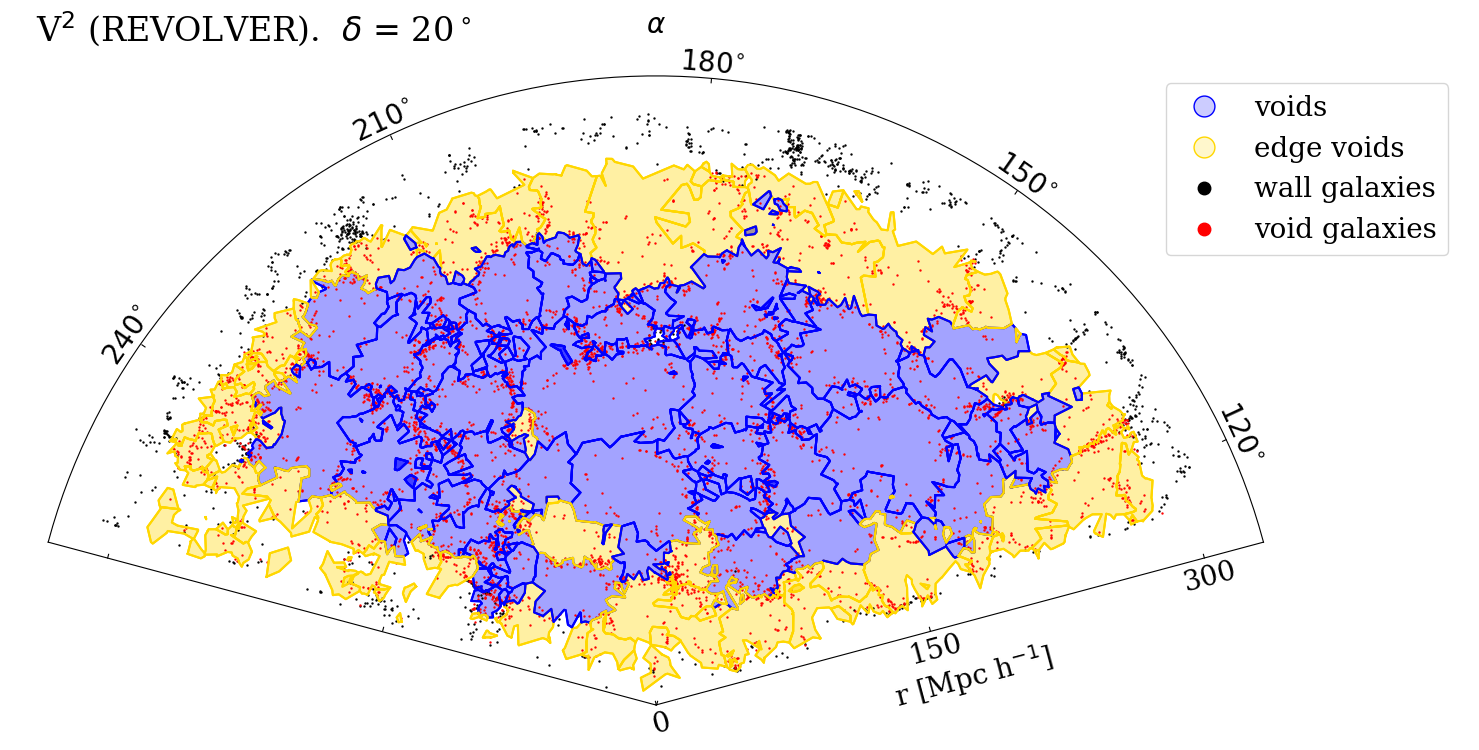

In [14]:
vsquared_slice_plot = VoidMapV2(vsquared_catalog.triangle, vsquared_catalog.galzone, vsquared_catalog.zonevoid,
                   vsquared_catalog.voids, vsquared_catalog.galaxies)

plt.rcParams.update({'font.size': 20, 'font.family':'serif',"axes.titley":1.03 })

graph = vsquared_slice_plot.plot_survey(20,5,
    110, 260, 0, 0.114,"V$^2$ (REVOLVER). ", graph = None, zlimits = True, rot = 265, 
    colors = ['gold','blue'],include_gals=True,alpha=0.2, border_alpha = 1, mag_limit=-20, 
    horiz_legend_offset=0.9, galaxy_point_size=.5, plot_sdss=False)
